In [1]:
import os
import random
import string
from PIL import Image, ImageDraw, ImageFont
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import torch
import torchvision  # Add this line
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
import shutil
from torchvision.transforms.functional import to_pil_image

In [3]:
# 数据转换
transform = transforms.Compose([
    transforms.ToTensor()
])

# 自定义数据集
class WatermarkRemovalDataset(Dataset):
    def __init__(self, watermarked_dir, mask_dir, clean_dir, transform=None):
        self.watermarked_dir = watermarked_dir
        self.mask_dir = mask_dir
        self.clean_dir = clean_dir
        self.images = sorted(os.listdir(watermarked_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        watermarked_path = os.path.join(self.watermarked_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        clean_path = os.path.join(self.clean_dir, self.images[idx])

        watermarked_img = Image.open(watermarked_path).convert("RGB")
        mask_img = Image.open(mask_path).convert("L")  # Mask is 单通道
        clean_img = Image.open(clean_path).convert("RGB")

        if self.transform:
            watermarked_img = self.transform(watermarked_img)
            mask_img = self.transform(mask_img)
            clean_img = self.transform(clean_img)

        # 返回四个值：watermarked_img, mask_img, clean_img, filename
        return watermarked_img, mask_img, clean_img, self.images[idx]

# 自定义 collate_fn
def custom_collate_fn(batch):
    watermarked_imgs, masks, clean_imgs, filenames = zip(*batch)
    return list(watermarked_imgs), list(masks), list(clean_imgs), list(filenames)

# 数据加载器
train_dataset = WatermarkRemovalDataset(
    watermarked_dir="./web_dataset_split/test1/watermarked",
    mask_dir="./web_test_mask_results",
    clean_dir="./web_dataset_split/test1/no_watermark",
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=custom_collate_fn
)


In [4]:
import torch.nn as nn

class WatermarkRemovalModel(nn.Module):
    def __init__(self):
        super(WatermarkRemovalModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # 输出值归一化到 [0, 1]
        )

    def forward(self, watermarked_img, mask):
        x = torch.cat((watermarked_img, mask), dim=1)  # 将图像和mask在通道维度拼接
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [10]:
from tqdm import tqdm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 10
LEARNING_RATE = 0.001

# 初始化模型、损失函数和优化器
model = WatermarkRemovalModel().to(DEVICE)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Starting training...")
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    # 使用 tqdm 包装数据加载器以显示进度条
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}") as progress_bar:
        for watermarked_imgs, masks, clean_imgs, file_names in progress_bar:
            batch_loss = 0  # 记录当前 batch 的损失
            for watermarked_img, mask, clean_img, file_name in zip(watermarked_imgs, masks, clean_imgs, file_names):
                watermarked_img = watermarked_img.to(DEVICE).unsqueeze(0)  # 添加 batch 维度
                mask = mask.to(DEVICE).unsqueeze(0)
                clean_img = clean_img.to(DEVICE).unsqueeze(0)

                optimizer.zero_grad()
                output = model(watermarked_img, mask)

                # 动态调整输出尺寸匹配 clean_img
                _, _, target_h, target_w = clean_img.shape
                output = F.interpolate(output, size=(target_h, target_w), mode='bilinear', align_corners=True)

                loss = criterion(output, clean_img)
                loss.backward()
                optimizer.step()

                batch_loss += loss.item()
                epoch_loss += loss.item()

            # 更新进度条显示当前 batch 的平均损失
            progress_bar.set_postfix({"Batch Loss": batch_loss / len(watermarked_imgs)})

    # 打印每个 epoch 的平均损失
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss / len(train_loader):.4f}")

# 保存模型
torch.save(model.state_dict(), "web_watermark_removal_model.pth")
print("Model saved.")


Starting training...


Epoch 1/10: 100%|██████████| 4000/4000 [00:57<00:00, 70.08it/s, Batch Loss=0.00307] 


Epoch 1/10, Loss: 0.0026


Epoch 2/10: 100%|██████████| 4000/4000 [00:57<00:00, 69.52it/s, Batch Loss=0.000451]


Epoch 2/10, Loss: 0.0013


Epoch 3/10: 100%|██████████| 4000/4000 [00:58<00:00, 68.00it/s, Batch Loss=0.000455]


Epoch 3/10, Loss: 0.0011


Epoch 4/10: 100%|██████████| 4000/4000 [00:58<00:00, 68.66it/s, Batch Loss=0.00147] 


Epoch 4/10, Loss: 0.0010


Epoch 5/10: 100%|██████████| 4000/4000 [00:58<00:00, 68.95it/s, Batch Loss=0.000511]


Epoch 5/10, Loss: 0.0010


Epoch 6/10: 100%|██████████| 4000/4000 [00:57<00:00, 69.94it/s, Batch Loss=0.00117] 


Epoch 6/10, Loss: 0.0009


Epoch 7/10: 100%|██████████| 4000/4000 [00:57<00:00, 69.71it/s, Batch Loss=0.000595]


Epoch 7/10, Loss: 0.0009


Epoch 8/10: 100%|██████████| 4000/4000 [00:57<00:00, 69.67it/s, Batch Loss=0.000479]


Epoch 8/10, Loss: 0.0009


Epoch 9/10: 100%|██████████| 4000/4000 [00:57<00:00, 69.53it/s, Batch Loss=0.00045] 


Epoch 9/10, Loss: 0.0009


Epoch 10/10: 100%|██████████| 4000/4000 [00:57<00:00, 69.32it/s, Batch Loss=0.00255] 

Epoch 10/10, Loss: 0.0009
Model saved.


In [12]:
from torchvision.transforms.functional import to_pil_image
import os

def remove_watermark(test_loader, model_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    model = WatermarkRemovalModel().to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    with torch.no_grad():
        for watermarked_imgs, masks, clean_imgs ,filenames in test_loader:  # filenames 从数据集中获取
            for watermarked_img, mask, clean_img ,filename in zip(watermarked_imgs, masks, clean_imgs, filenames):
                watermarked_img = watermarked_img.to(DEVICE).unsqueeze(0)
                mask = mask.to(DEVICE).unsqueeze(0)

                output = model(watermarked_img, mask)

                # 动态调整输出尺寸
                original_size = watermarked_img.shape[2:]
                output = torch.nn.functional.interpolate(output, size=original_size, mode='bilinear', align_corners=True)

                output = output.squeeze(0).cpu()
                output_img = to_pil_image(output)

                # 保存文件，确保文件名和扩展名正确
                base_name, ext = os.path.splitext(filename)
                if ext.lower() not in [".jpg", ".jpeg", ".png"]:
                    ext = ".png"  # 默认扩展名
                output_path = os.path.join(output_dir, f"{base_name}{ext}")
                output_img.save(output_path)

                print(f"Saved: {output_path}")

    print("Watermark removal complete.")


In [13]:
test_dataset = WatermarkRemovalDataset(
    watermarked_dir="./web_dataset_split/test2/watermarked",
    mask_dir="./web_test_model_result/mask",
    clean_dir="./web_dataset_split/test2/no_watermark",
    transform=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=custom_collate_fn
)

output_dir="./web_test_model_result/watermark_removal_output"

remove_watermark(test_loader, "web_watermark_removal_model.pth", output_dir)


C:\Users\EdisonLai\AppData\Local\Temp\ipykernel_21512\2509909662.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

Saved: ./web_test_model_result/watermark_removal_output\777.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7770.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7771.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7772.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7773.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7774.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7775.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7776.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7777.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7778.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7779.jpeg
Saved: ./web_test_model_result/watermark_removal_output\778.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7780.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7781.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7782.jpeg
Saved: ./web

In [14]:
test_dataset = WatermarkRemovalDataset(
    watermarked_dir="./true_web_data/watermarked",
    mask_dir="./true_web_data/model2/predicted_mask",
    clean_dir="./true_web_data/no_watermark",
    transform=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=custom_collate_fn
)

output_dir="./true_web_data/model2/output_no_watermark"

remove_watermark(test_loader, "web_watermark_removal_model.pth", output_dir)



C:\Users\EdisonLai\AppData\Local\Temp\ipykernel_21512\2509909662.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

Saved: ./true_web_data/model2/output_no_watermark\00A5QK.jpg
Saved: ./true_web_data/model2/output_no_watermark\00DT57.jpg
Saved: ./true_web_data/model2/output_no_watermark\01FAOU.jpg
Saved: ./true_web_data/model2/output_no_watermark\01IMVE.jpg
Saved: ./true_web_data/model2/output_no_watermark\01UZBZ.jpg
Saved: ./true_web_data/model2/output_no_watermark\02Z6TT.jpg
Saved: ./true_web_data/model2/output_no_watermark\03UINF.jpg
Saved: ./true_web_data/model2/output_no_watermark\03YTHF.jpg
Saved: ./true_web_data/model2/output_no_watermark\0AH3BR.jpg
Saved: ./true_web_data/model2/output_no_watermark\0B9T85.jpg
Saved: ./true_web_data/model2/output_no_watermark\0BJW9C.jpg
Saved: ./true_web_data/model2/output_no_watermark\0BWU6O.jpg
Saved: ./true_web_data/model2/output_no_watermark\0F6BBP.jpg
Saved: ./true_web_data/model2/output_no_watermark\0GAHD1.jpg
Saved: ./true_web_data/model2/output_no_watermark\0GP2FA.jpg
Saved: ./true_web_data/model2/output_no_watermark\0GR7CG.jpg
Saved: ./true_web_data/m

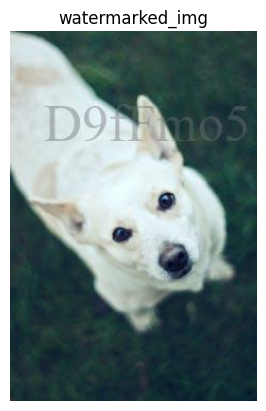

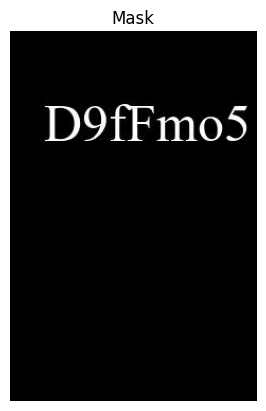

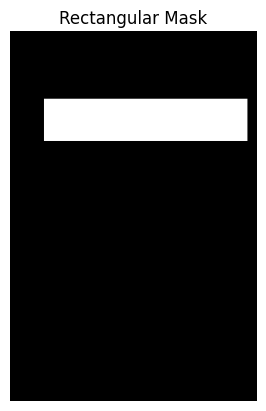

ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

In [30]:
from skimage.metrics import structural_similarity as ssim
from skimage.io import imread
from skimage.morphology import dilation, square
import matplotlib.pyplot as plt
from natsort import natsorted
import numpy as np

def calculate_accuracy_with_only_watermark_region(clean_images_dir, watermarked_images_dir, processed_images_dir, mask_dir, similarity_threshold=0.9):
    """
    計算去浮水印模型的正確率，只考慮浮水印及其周圍區域，不考慮其他區域。

    :param clean_images_dir: 原始圖片文件夾路徑
    :param processed_images_dir: 去浮水印圖片文件夾路徑
    :param mask_dir: 浮水印區域掩膜文件夾路徑，該掩膜標識浮水印位置（1表示浮水印區域，0表示非浮水印區域）
    :param similarity_threshold: SSIM 判斷閾值
    :return: 正確率，平均 SSIM 分數
    """
    clean_images = natsorted(os.listdir(clean_images_dir))
    watermarked_images = natsorted(os.listdir(watermarked_images_dir))
    processed_images = natsorted(os.listdir(processed_images_dir))
    masks = natsorted(os.listdir(mask_dir))

    if len(clean_images) != len(processed_images) or len(clean_images) != len(masks):
        raise ValueError("圖片數量或掩膜數量不一致！")

    total_images = len(clean_images)
    correct_count = 0
    total_score = 0
    time = 1

    for clean_image, watermarked_image, processed_image, mask_name in zip(clean_images, watermarked_images, processed_images, masks):
        # 讀取圖片和掩膜
        clean_img = imread(os.path.join(clean_images_dir, clean_image))
        watermarked_img = imread(os.path.join(watermarked_images_dir, watermarked_image))
        processed_img = imread(os.path.join(processed_images_dir, processed_image))
        mask = imread(os.path.join(mask_dir, mask_name))

        # 掩膜區域：1 表示浮水印區域
        watermark_region = mask > 0.4

        # 將浮水印區域包裹成矩形框
        coords = np.argwhere(watermark_region)
        if coords.size == 0:
            raise ValueError(f"掩膜 {mask_name} 中沒有標註浮水印區域！")
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
        rectangular_mask = np.zeros_like(mask, dtype=bool)
        rectangular_mask[y_min:y_max+1, x_min:x_max+1] = True

        if time > 0:
            plt.imshow(watermarked_img)
            plt.title("watermarked_img")
            plt.axis('off')
            plt.show()
            plt.imshow(mask, cmap='gray')
            plt.title("Mask")
            plt.axis('off')
            plt.show()
            # 顯示矩形框掩膜
            plt.imshow(rectangular_mask, cmap='gray')
            plt.title("Rectangular Mask")
            plt.axis('off')
            plt.show()
            time = time - 1

        # 計算 SSIM 時，僅考慮矩形框內的浮水印區域
        clean_img_masked = np.where(rectangular_mask[..., None], clean_img, 0)  # 使用掩膜保留浮水印區域
        processed_img_masked = np.where(rectangular_mask[..., None], processed_img, 0)

        data_range = clean_img.max() - clean_img.min()
        # Ensure win_size is valid for small regions
        min_dim = min(clean_img_masked.shape[:2])
        win_size = min(7, min_dim) if min_dim >= 7 else min_dim  # Ensure win_size does not exceed the image size

        # Avoid passing invalid win_size for small images
        if win_size < 3:
            win_size = 3  # Ensure win_size is at least 3 for very small regions

        score, _ = ssim(clean_img_masked, processed_img_masked, multichannel=True, data_range=data_range, full=True, win_size=win_size)
        # 判定是否符合閾值
        if score >= similarity_threshold:
            correct_count += 1

        # 累加 SSIM 分數
        total_score += score

    accuracy = correct_count / total_images
    average_score = total_score / total_images  # 計算平均 SSIM 分數
    return accuracy, average_score

# Step 3: 設定圖片文件夾路徑並計算正確率
clean_images_dir = "web_dataset_split/test2/no_watermark"  # 原始圖片路徑
watermarked_images_dir = "web_dataset_split/test2/watermarked"  # 原始浮水印圖片路徑
processed_images_dir = "web_test_model_result/watermark_removal_output"  # 浮水印結果路徑
mask_dir = "web_dataset_split/test2/masks"  # 浮水印區域掩膜的路徑

similarity_threshold = 0.9  # 設置 SSIM 判斷閾值

accuracy, average_score = calculate_accuracy_with_only_watermark_region(
    clean_images_dir, watermarked_images_dir, processed_images_dir, mask_dir, similarity_threshold
)

print(f"去浮水印正確率: {accuracy * 100:.2f}%")
print(f"平均 SSIM 分數: {average_score:.4f}")
